## This notebook is used to calculate log2-fold changes in OTUs and creates Figure 4 and Supplemental Figures 15 and 16 and Supplemental Table 6.

In [1]:
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
library(ggplot2)
library(metagenomeSeq)
library(biomformat)
library(interactiveDisplay)
library(reshape)
library(RColorBrewer)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

In [4]:
ps = readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/ps.merged")
# Read in phyloseq object
ps.norm = transform_sample_counts(ps, function(x) x/sum(x))
# Normalize sample counts

In [3]:
ps.biom = ps
# Copy phyloseq object (note, not using normalized ps)
biom = make_biom(data = t(otu_table(ps.biom)), observation_metadata= tax_table(ps.biom), sample_metadata = sample_data(ps.biom))
# turn phyloseq into a biom table with OTU table, taxonomy, and sample data
biom.MRexp = biom2MRexperiment(biom)
# turns our biom file into the type of file needed for this analysis (an MRexperiment object)
biom.MRexp = biom.MRexp[,-which(is.na(pData(biom.MRexp)$pH))]
biom.MRexp
# Create .MRexp object

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

MRexperiment (storageMode: environment)
assayData: 19988 features, 95 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: 15S-NT-19O 15S-NT-21O ... 15S-WB-U05O (95 total)
  varLabels: Barcodes Sample_ID ... Soil_Class (103 total)
  varMetadata: labelDescription
featureData
  featureNames: sq1 sq2 ... sq20020 (19988 total)
  fvarLabels: Kingdom Phylum ... Species (7 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [4]:
#Preparing object for metegenomeseq analysis
    MRexp = biom.MRexp
    MRexp = cumNorm(MRexp, cumNormStat(MRexp, qFlag=TRUE, pFlag = FALSE))
    ModelData = pData(MRexp)
# Setting factors to be proper values
    ModelData$pH = as.numeric(ModelData$pH)
    ModelData$TC_pct = as.numeric(ModelData$TC_pct)
    ModelData$Veg_Comm = make.names(ModelData$Veg_Comm)
    ModelData$Burned_Unburned = as.factor(ModelData$Burned_Unburned)
    ModelData$Burned_Unburned = ordered(ModelData$Burned_Unburned, levels = c('Unburned','Burned'))
# Establishing model formula
    model = model.matrix(~Veg_Comm+TC_pct+pH+Burned_Unburned, data=ModelData)
# Assigning settings
    settings = zigControl(tol = 1e-04, maxit = 30, verbose = TRUE, dfMethod = "default", pvalMethod = "default")
# Running fit
    fit = fitZig(obj=MRexp, mod=model, control = settings, useCSSoffset = TRUE, zeroMod = NULL, useMixedModel = FALSE)

it= 0, nll=125.66, log10(eps+1)=Inf, stillActive=19988
it= 1, nll=116.16, log10(eps+1)=Inf, stillActive=19328
it= 2, nll=114.80, log10(eps+1)=Inf, stillActive=14425
it= 3, nll=116.63, log10(eps+1)=Inf, stillActive=10049
it= 4, nll=115.04, log10(eps+1)=Inf, stillActive=8302
it= 5, nll=113.60, log10(eps+1)=Inf, stillActive=6840
it= 6, nll=116.83, log10(eps+1)=Inf, stillActive=3987
it= 7, nll=119.50, log10(eps+1)=Inf, stillActive=2304
it= 8, nll=119.73, log10(eps+1)=Inf, stillActive=1913
it= 9, nll=120.02, log10(eps+1)=Inf, stillActive=1695
it=10, nll=120.57, log10(eps+1)=Inf, stillActive=1438
it=11, nll=120.88, log10(eps+1)=Inf, stillActive=1302
it=12, nll=120.90, log10(eps+1)=Inf, stillActive=1299
it=13, nll=120.91, log10(eps+1)=Inf, stillActive=1297
it=14, nll=120.93, log10(eps+1)=Inf, stillActive=1295
it=15, nll=120.94, log10(eps+1)=Inf, stillActive=1294
it=16, nll=120.95, log10(eps+1)=Inf, stillActive=1293
it=17, nll=120.95, log10(eps+1)=Inf, stillActive=1293
it=18, nll=120.96, log10

In [5]:
    EffSamp = calculateEffectiveSamples(fit)
    MeanEffSamp = mean(EffSamp[!is.na(EffSamp)])
# Effective sample size is calculated, and the average values of this is determined
    rareFeatures = which(rowSums(MRcounts(MRexp) > 0) < MeanEffSamp)
# These are the taxa that that had less than the average number of effective samples
# As recommended in the vignette: https://www.bioconductor.org/packages/devel/bioc/vignettes/metagenomeSeq/inst/doc/metagenomeSeq.pdf
    MRexp = MRexp[-rareFeatures, ]
# Take the data object and remove the rareFeatures (taxa)
# Re-run the analyses below.
    MRexp = cumNorm(MRexp, cumNormStat(MRexp, qFlag=TRUE, pFlag = FALSE))
    ModelData = pData(MRexp)

Default value being used.


In [6]:
# Resetting the model parameters
    ModelData$pH = as.numeric(ModelData$pH)
    ModelData$TC_pct = as.numeric(ModelData$TC_pct)
    ModelData$Veg_Comm = make.names(ModelData$Veg_Comm)
    ModelData$Burned_Unburned = as.factor(ModelData$Burned_Unburned)
    ModelData$Burned_Unburned = ordered(ModelData$Burned_Unburned, levels = c('Unburned','Burned'))

    model = model.matrix(~Veg_Comm+TC_pct+pH+Burned_Unburned, data=ModelData)
# Creating the model that we will use to analyze our data.
    fit = fitZig(obj=MRexp, mod=model, control = settings, useCSSoffset = TRUE, zeroMod = NULL, useMixedModel = FALSE)
#Re-running the fit with the EffSamp - normalized data  

it= 0, nll=130.75, log10(eps+1)=Inf, stillActive=488
it= 1, nll=139.74, log10(eps+1)=0.03, stillActive=77
it= 2, nll=140.02, log10(eps+1)=0.02, stillActive=28
it= 3, nll=140.16, log10(eps+1)=0.02, stillActive=6
it= 4, nll=140.09, log10(eps+1)=0.03, stillActive=2
it= 5, nll=140.08, log10(eps+1)=0.00, stillActive=0


In [7]:
    modeldesign = fit$fit$design
    modelfit = fit$fit
    modelfit.treat = treat(modelfit, lfc=0)
    resultsBurn=topTreat(modelfit.treat, coef=8, number=7500)
    results=merge(data.frame(),resultsBurn,by=0, all=TRUE, suffixes=c(".Burn"))
# Extracting the results of interest

In [8]:
row.names(results)=results$Row.names
# Carrying the proper OTU IDs along
results= merge(results,fData(biom.MRexp),by=0,all=TRUE)
results = results[,2:dim(results)[2]]
colnames(results)[1]="OTU"
results$sigBurn = ifelse(results$adj.P.Val<0.05,1,0.5)
# Creating a variable that sets what will be the alpha values for plotting the results

Warning message in merge.data.frame(results, fData(biom.MRexp), by = 0, all = TRUE):
“column name ‘Row.names’ is duplicated in the result”

In [9]:
# Summarizing and saving results
Responders16S = results %>%
    filter(!is.na(OTU))%>%
    filter(adj.P.Val<0.05)%>%
    arrange(-logFC)
#write.csv(Responders16S,"Responders16S.csv")

In [3]:
#saveRDS(results,"../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/l2fc.df")
results = readRDS("../../../data/Seq_data/16S/CHTC/Dada2_Results_Full/l2fc.df")

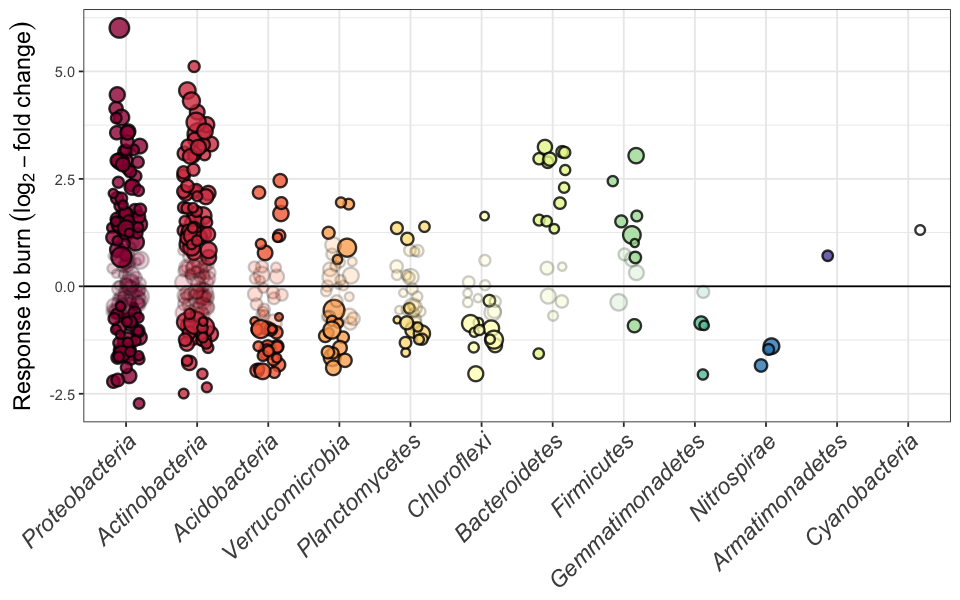

In [4]:
options(repr.plot.width=8, repr.plot.height=5)

# Get rid of any NA OTUs
FullResults = results%>%
    filter(!is.na(OTU))%>%
    arrange(Phylum)

# Remove any OTUs with unknown phyla, unclassified
FullResults = FullResults[!is.na(FullResults$Phylum),]
FullResults = FullResults[FullResults$Phylum!='Bacteria_unclassified(0)',]
# Make burn response significance a factor
FullResults$sigBurn = as.factor(FullResults$sigBurn)

# Getting the most abundant phyla and ordering them
TaxOrder = FullResults%>%
    group_by(Phylum)%>%
    summarize(Total=n()) %>% 
    arrange(-Total)
TaxOrder = TaxOrder$Phylum[1:15]
FullResults$Phylum = ordered(FullResults$Phylum, levels=TaxOrder)

# Making the plot
p = ggplot(FullResults,aes(x=Phylum, y=logFC, alpha=sigBurn, fill=Phylum))
p = p + geom_jitter(shape=21, stroke=1, aes(size=AveExpr), width=0.2)
p = p + scale_size(guide=FALSE)
p = p + scale_alpha_manual(guide=FALSE, values=c(0.2,0.8))
p = p + scale_fill_manual(values=c(brewer.pal(11,"Spectral"),"white"))
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=45, hjust=1, size=14))
p = p + theme(axis.title.y = element_text(size=14))
p = p + theme(legend.position="none")
p = p + geom_hline(yintercept=0) 
p = p + ylab(expression(Response~to~burn~(log[2]-fold~change)))
p = p + theme(axis.text.x = element_text(face="italic"),
             legend.text = element_text(face="italic"),
             axis.title.x = element_blank())
p

In [6]:
# Pulling in the genera identified as being responsive to organic matter removal by Wilhelm et al. (2017)
# From the Long Term Soil Productivity studies

LTSP = c("Blastococcus","Coccomyxa","Acidiphilum","Clostridium","Massilia","Cryocola","Nocardia","Janthinobacterium",
          "Flavisolibacter","Methyloferula","Terriglobus","Mucilaginibacter","Edaphobacter","Herbaspirillum","Granulicella",
          "Inquilinus","Rudaea","Phenylobacterium","Caulobacter","Methylibium","Actinomycetospora","Ramlibacter","Koribacter",
          "Telmatospirillum","Kitasatospora","Solibacter","Mycobacterium","Acidocella","Rhodoplanes","Kribbella",
          "Streptomyces")
df.merged = results
df.merged$LTSP = ""
df.merged$LTSP[df.merged$Genus %in% LTSP]="Yes"
results$LTSP = ""
results$LTSP[results$Genus %in% LTSP]="Yes"

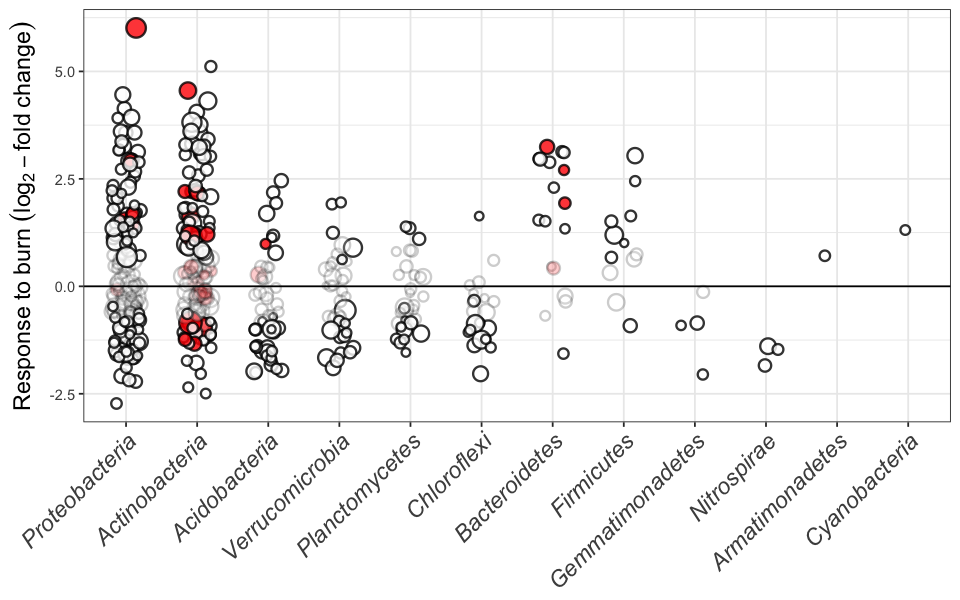

In [8]:
options(repr.plot.width=8, repr.plot.height=5)

FullResults = results%>%
    filter(!is.na(OTU))%>%
    arrange(Phylum)

FullResults = FullResults[!is.na(FullResults$Phylum),]
FullResults = FullResults[FullResults$Phylum!='Bacteria_unclassified(0)',]
FullResults$sigBurn = as.factor(FullResults$sigBurn)


TaxOrder = FullResults%>%
    group_by(Phylum)%>%
    summarize(Total=n()) %>% 
    arrange(-Total)
TaxOrder = TaxOrder$Phylum[1:15]
FullResults$Phylum = ordered(FullResults$Phylum, levels=TaxOrder)

#p = ggplot(FullResults[FullResults$Family %in% TaxOrder[1:nTax],],aes(x=Phylum, y=logFC, alpha=sigSeverity, fill=Phylum))
p = ggplot(FullResults,aes(x=Phylum, y=logFC, alpha=sigBurn, fill=LTSP))
p = p + geom_jitter(shape=21, stroke=1, aes(size=AveExpr), width=0.2)
p = p + scale_size(guide=FALSE)
p = p + scale_alpha_manual(guide=FALSE, values=c(0.2,0.8))
p = p + scale_fill_manual(values=c("white","red","red"))
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=45, hjust=1, size=14))
p = p + theme(axis.title.y = element_text(size=14))
p = p + theme(legend.position="none")
p = p + geom_hline(yintercept=0) 
p = p + ylab(expression(Response~to~burn~(log[2]-fold~change)))
p = p + theme(axis.text.x = element_text(face="italic"),
             legend.text = element_text(face="italic"),
             axis.title.x = element_blank())
p

### Calculating relative abundance of some of the more abundant OTUs

In [6]:
# melting phyloseq object into massive dataframe
mdf = psmelt(ps.norm)

In [19]:
# Finding the most abundant taxa that are significantly enriched (l2FC>2) in burned plots
Responders = results %>%
    dplyr::filter(sigBurn == 1)%>%
    dplyr::filter(logFC > 2)%>%
    arrange(-AveExpr)
TopResp = Responders[1:6,]$OTU
TopResp

[1] "sq1"  "sq3"  "sq8"  "sq7"  "sq18" "sq20"

Warning message:
“Removed 250 rows containing non-finite values (stat_boxplot).”

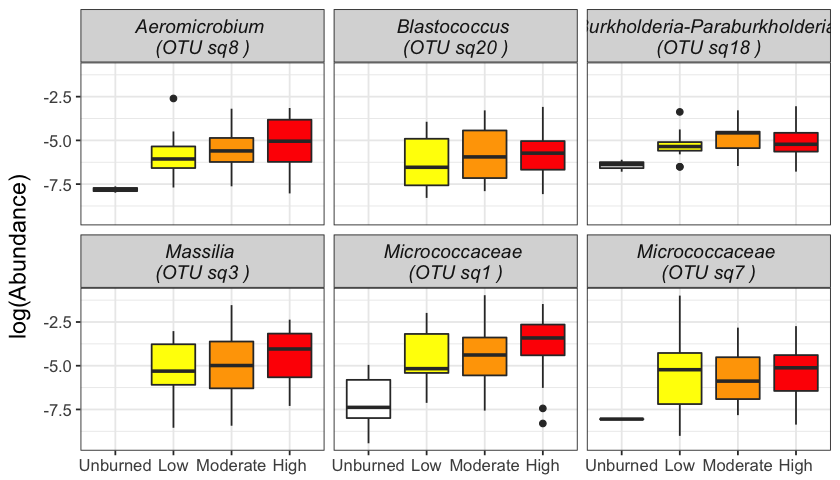

In [21]:
# Plotting the 6 most abundant fire-responders

options(repr.plot.width=7, repr.plot.height=4)
d = mdf%>%
    filter(OTU %in% TopResp)%>%
    mutate(Namer = ifelse(Genus=="",paste(Family),paste(Genus)))%>%
    mutate(Name = paste(Namer,"\n(OTU",OTU,")"),sep="")

p = ggplot(d)
p = p + geom_boxplot(aes(Severity_Class, log(Abundance), fill=Severity_Class))
#p = p + facet_grid(~Name~Land_Class+Org_or_Min, scales="free")
p = p + facet_wrap(~Name, ncol=3)
p = p + guides(color=FALSE, fill=FALSE)
p = p + scale_fill_manual(values=c("white","yellow","orange","red"))
#p = p + theme(strip.text.y = element_text(angle=0, hjust=0))
p = p + theme_bw()
p = p + theme(strip.text.x = element_text(face="italic", size=11.5), 
              axis.title.x = element_blank(),
             axis.text.x = element_text(size=10),
             axis.text.y = element_text(size=10),
             axis.title.y = element_text(size=14))
p

In [22]:
# Running stats on trends in abundant positive responders
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq1",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq3",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq7",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq8",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq18",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq20",])
summary(a)

                     Df  Sum Sq Mean Sq F value   Pr(>F)    
Burn_Severity_Index   1 0.05325 0.05325    26.2 1.49e-06 ***
Residuals           100 0.20320 0.00203                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df  Sum Sq  Mean Sq F value   Pr(>F)    
Burn_Severity_Index   1 0.00990 0.009901   11.53 0.000984 ***
Residuals           100 0.08588 0.000859                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df  Sum Sq  Mean Sq F value Pr(>F)  
Burn_Severity_Index   1 0.00499 0.004985   4.579 0.0348 *
Residuals           100 0.10887 0.001089                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df   Sum Sq   Mean Sq F value   Pr(>F)    
Burn_Severity_Index   1 0.002116 0.0021160   18.22 4.48e-05 ***
Residuals           100 0.011613 0.0001161                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df   Sum Sq   Mean Sq F value Pr(>F)  
Burn_Severity_Index   1 0.000395 0.0003953   6.855 0.0102 *
Residuals           100 0.005766 0.0000577                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df   Sum Sq   Mean Sq F value   Pr(>F)    
Burn_Severity_Index   1 0.000782 0.0007822   15.29 0.000168 ***
Residuals           100 0.005115 0.0000512                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [14]:
# Looking also at the negative responders 
# Here defined as L2FC less than -1 (i.e., more than half as abundant in burned sites)
# And taking the more abundant taxa
NegResponders = results %>%
    dplyr::filter(sigBurn == 1)%>%
    dplyr::filter(logFC < -1)%>%
   arrange(-AveExpr)
#    arrange(logFC)
TopNegResp = NegResponders[1:8,]$OTU
TopNegResp

[1] "sq23"  "sq26"  "sq87"  "sq12"  "sq160" "sq64"  "sq117" "sq93" 

Warning message:
“Removed 396 rows containing non-finite values (stat_boxplot).”

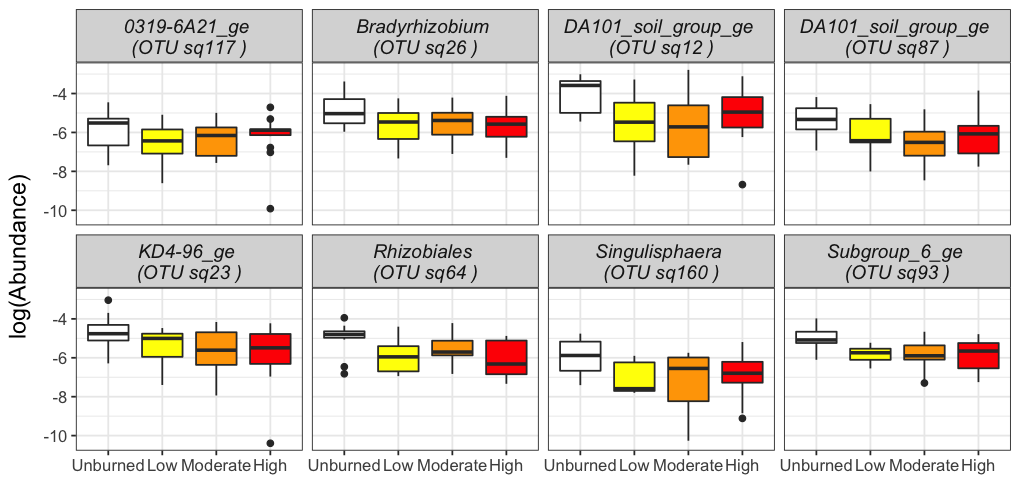

In [15]:

options(repr.plot.width=8.5, repr.plot.height=4)
d = mdf%>%
    filter(OTU %in% TopNegResp)%>%
    mutate(Namer = ifelse(Genus=="",paste(Order),paste(Genus)))%>%
    mutate(Name = paste(Namer,"\n(OTU",OTU,")"),sep="")

p = ggplot(d)
p = p + geom_boxplot(aes(Severity_Class, log(Abundance), fill=Severity_Class))
#p = p + facet_grid(~Name~Land_Class+Org_or_Min, scales="free")
p = p + facet_wrap(~Name, ncol=4)
p = p + guides(color=FALSE, fill=FALSE)
p = p + scale_fill_manual(values=c("white","yellow","orange","red"))
#p = p + theme(strip.text.y = element_text(angle=0, hjust=0))
p = p + theme_bw()
p = p + theme(strip.text.x = element_text(face="italic", size=11.5), 
              axis.title.x = element_blank(),
             axis.text.x = element_text(size=10),
             axis.text.y = element_text(size=10),
             axis.title.y = element_text(size=14))
p

In [17]:
# Running stats on trends in abundant negative responders
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq117",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq26",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq12",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq87",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq23",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq64",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq160",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq93",])
summary(a)

                     Df    Sum Sq   Mean Sq F value  Pr(>F)   
Burn_Severity_Index   1 0.0000434 4.338e-05   9.519 0.00263 **
Residuals           100 0.0004557 4.560e-06                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df    Sum Sq   Mean Sq F value  Pr(>F)   
Burn_Severity_Index   1 0.0002002 2.002e-04   7.384 0.00776 **
Residuals           100 0.0027111 2.711e-05                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df  Sum Sq   Mean Sq F value Pr(>F)
Burn_Severity_Index   1 0.00016 0.0001603   1.192  0.277
Residuals           100 0.01344 0.0001344               

                     Df    Sum Sq   Mean Sq F value Pr(>F)  
Burn_Severity_Index   1 0.0000943 9.430e-05   6.337 0.0134 *
Residuals           100 0.0014882 1.488e-05                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df   Sum Sq   Mean Sq F value  Pr(>F)   
Burn_Severity_Index   1 0.000404 0.0004045   9.906 0.00217 **
Residuals           100 0.004083 0.0000408                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df   Sum Sq   Mean Sq F value  Pr(>F)   
Burn_Severity_Index   1 0.000148 0.0001479   11.21 0.00115 **
Residuals           100 0.001320 0.0000132                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df    Sum Sq   Mean Sq F value Pr(>F)  
Burn_Severity_Index   1 1.069e-05 1.070e-05   3.615 0.0601 .
Residuals           100 2.958e-04 2.958e-06                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     Df    Sum Sq  Mean Sq F value   Pr(>F)    
Burn_Severity_Index   1 0.0001700 1.70e-04   17.56 6.01e-05 ***
Residuals           100 0.0009679 9.68e-06                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1